# This notebook trains machine learning models for the Retail Sales Prediction Dashboard using retail sales data (100k records, India stores, 2019-2023). It includes:
# - **Preprocessing**: Handle dates, engineer features, encode categories.
# - **Models**: Linear Regression, Random Forest, XGBoost, ARIMA, LSTM—trained and tuned.
# - **Evaluation**: MSE, R², visualizations (feature importance, forecasts).
# - **Output**: Models saved in `models/` for dashboard integration.

# Dataset: [Kaggle Store Sales Data](https://www.kaggle.com/datasets/abuhumzakhan/store-data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import pickle
import os

In [2]:
# Configure plotting
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# Create models directory
os.makedirs("models", exist_ok=True)

print("Setup complete, models will be saved in 'models/'")

Setup complete, models will be saved in 'models/'


#2. Load and Preprocess Data

In [4]:
# Load dataset
file_path = "/content/store_sales_data (2).csv"  # Update with your path
try:
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows, {len(df.columns)} columns")
except FileNotFoundError:
    print("Error: store_sales_data.csv not found!")
    df = None

Loaded 100000 rows, 25 columns


In [5]:
# Preprocess if loaded
if df is not None:
    # Handle missing values
    df.dropna(inplace=True)

    # Convert date columns
    date_columns = ['Date of Birth', 'Sales Date', 'Order Date', 'Ship Date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df.dropna(subset=date_columns, inplace=True)

    # Feature engineering
    df['Customer Age'] = (datetime.now() - df['Date of Birth']).dt.days // 365
    df['Fulfillment Time'] = (df['Ship Date'] - df['Order Date']).dt.days
    df['CLV'] = df.groupby('Customer ID')['Sales'].transform('sum')
    df['Discount Impact'] = df['Sales'] * df['Discount']
    df['Product Popularity'] = df.groupby('Product ID')['Quantity'].transform('sum')
    df['Year'] = df['Sales Date'].dt.year

    # Encode categorical variables
    categorical_columns = ['Outlet Type', 'City Type', 'Category of Goods',
                         'Region', 'Country', 'Segment', 'Ship Mode',
                         'State', 'Sub-Category']
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    # Save preprocessed data
    df.to_csv("processed_store_sales_data.csv", index=False)
    print("Preprocessed data saved as 'processed_store_sales_data.csv'")
    display(df.head())

Preprocessed data saved as 'processed_store_sales_data.csv'


,Customer ID,Customer Name,Last Name,Date of Birth,Sales,Year,Sales Date,Order ID,Order Date,Ship Date,...,Sub-Category_Mops,Sub-Category_Pizzas,Sub-Category_Refrigerators,Sub-Category_Sandwiches,Sub-Category_Sofas,Sub-Category_Tables,Sub-Category_Tomatoes,Sub-Category_Utensils,Sub-Category_Washing Machines,Sub-Category_Yogurt
0,CUST000001,Curtis,Krause,1973-11-29,3344.69,2023,2023-03-11,ORD000001,2020-04-13,2020-04-18,...,False,False,False,False,False,False,False,False,False,False
1,CUST000002,Jeremy,Foster,1987-08-30,37094.41,2023,2023-09-09,ORD000002,2021-01-08,2021-01-11,...,False,True,False,False,False,False,False,False,False,False
2,CUST000003,Ariel,Mccann,1980-12-15,35501.08,2022,2022-08-15,ORD000003,2020-08-11,2020-08-16,...,False,False,False,False,False,False,False,False,False,False
3,CUST000004,Colleen,Maynard,1989-05-23,8969.33,2021,2021-01-23,ORD000004,2021-10-10,2021-10-16,...,False,False,False,False,False,False,False,False,False,False
4,CUST000005,Gina,Holden,1957-12-31,35530.44,2020,2020-12-24,ORD000005,2019-01-22,2019-01-25,...,False,False,False,False,False,False,True,False,False,False


# 3. Prepare Features and Target

In [6]:
# Define features and target
if df is not None:
    features = ['Quantity', 'Discount', 'Fulfillment Time', 'Customer Age',
                'CLV', 'Discount Impact', 'Product Popularity', 'Year', 'Postal Code']
    X = df[features]
    y = df['Sales']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set: {X_train.shape[0]} rows")
    print(f"Test set: {X_test.shape[0]} rows")

Training set: 80000 rows
Test set: 20000 rows


#4. Train ML Models

In [7]:
# Train Linear Regression
if df is not None:
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred_lr = lr_model.predict(X_test_scaled)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    print(f"Linear Regression - MSE: {mse_lr:.2f}")
    print(f"Linear Regression - R²: {r2_lr:.2f}")

    # Save model and scaler
    with open("models/linear_regression_model.pkl", "wb") as f:
        pickle.dump(lr_model, f)
    with open("models/scaler_lr.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print("Linear Regression model and scaler saved in 'models/'")

Linear Regression - MSE: 0.00
Linear Regression - R²: 1.00
Linear Regression model and scaler saved in 'models/'


##XGBoost

In [8]:
# Train XGBoost
if df is not None:
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    print(f"XGBoost - MSE: {mse_xgb:.2f}")
    print(f"XGBoost - R²: {r2_xgb:.2f}")

    # Save model and scaler
    with open("models/xgboost_model.pkl", "wb") as f:
        pickle.dump(xgb_model, f)
    with open("models/scaler_xgb.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print("XGBoost model and scaler saved in 'models/'")

XGBoost - MSE: 3229.85
XGBoost - R²: 1.00
XGBoost model and scaler saved in 'models/'


##Random Forest with Hyperparameter Tuning

In [12]:
if df is not None:
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred_rf = rf_model.predict(X_test_scaled)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"Random Forest - MSE: {mse_rf:.2f}")
    print(f"Random Forest - R²: {r2_rf:.2f}")

    # Save model
    with open("models/random_forest_model.pkl", "wb") as f:
        pickle.dump(rf_model, f)
    print("Random Forest model saved in 'models/'")

Random Forest - MSE: 0.33
Random Forest - R²: 1.00
Random Forest model saved in 'models/'


# 5. Time Series Forecasting

In [13]:
if df is not None:
    monthly_sales = df.groupby(df['Sales Date'].dt.to_period('M'))['Sales'].sum().reset_index()
    monthly_sales['Sales Date'] = monthly_sales['Sales Date'].dt.to_timestamp()
    monthly_sales.set_index('Sales Date', inplace=True)

    # Split data (90/10 for better training)
    split_index = int(len(monthly_sales) * 0.9)
    train_data = monthly_sales.iloc[:split_index]
    test_data = monthly_sales.iloc[split_index:]

    # Train ARIMA with fixed order
    arima_model = ARIMA(train_data['Sales'], order=(1, 1, 1))
    arima_fit = arima_model.fit()

    # Forecast
    y_pred_arima = arima_fit.forecast(steps=len(test_data))
    mse_arima = mean_squared_error(test_data['Sales'], y_pred_arima)
    r2_arima = r2_score(test_data['Sales'], y_pred_arima)
    print(f"ARIMA - MSE: {mse_arima:.2f}")
    print(f"ARIMA - R²: {r2_arima:.2f}")

    # Save model
    with open("models/arima_model.pkl", "wb") as f:
        pickle.dump(arima_fit, f)
    print("ARIMA model saved in 'models/'")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA - MSE: 4059817324257.27
ARIMA - R²: -0.08
ARIMA model saved in 'models/'


In [17]:
# %% [markdown]
# ### 6.2 LSTM

# %%
# Prepare LSTM data
if df is not None:
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(train_data['Sales'].values.reshape(-1, 1))
    y_test_scaled = scaler.transform(test_data['Sales'].values.reshape(-1, 1))

    # Create sequences
    def create_sequences(data, timesteps=6):
        X, y = [], []
        for i in range(len(data) - timesteps):
            X.append(data[i:i + timesteps])
            y.append(data[i + timesteps])
        return np.array(X), np.array(y)

    timesteps = 6
    X_train_lstm, y_train_lstm = create_sequences(y_train_scaled, timesteps)

    # Check if test data has enough samples
    if len(y_test_scaled) > timesteps:
        X_test_lstm, y_test_lstm = create_sequences(y_test_scaled, timesteps)
    else:
        print("Warning: Not enough test data for LSTM sequences. Using train data for demo.")
        X_test_lstm, y_test_lstm = X_train_lstm[-1:], y_train_lstm[-1:]

    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

    # Build LSTM
    lstm_model = Sequential([
        Input(shape=(timesteps, 1)),
        LSTM(100, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train
    history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=200,
                            batch_size=32, validation_split=0.2, verbose=1)

    # Predict
    y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)
    y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)
    y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

    # Evaluate
    mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
    r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
    print(f"LSTM - MSE: {mse_lstm:.2f}")
    print(f"LSTM - R²: {r2_lstm:.2f}")

    # Save model
    lstm_model.save("models/lstm_model.h5")
    print("LSTM model saved in 'models/'")

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - loss: 0.5020 - val_loss: 0.4689
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.4622 - val_loss: 0.4330
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4232 - val_loss: 0.3952
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3932 - val_loss: 0.3539
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3475 - val_loss: 0.3100
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.3004 - val_loss: 0.2631
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2523 - val_loss: 0.2128
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2160 - val_loss: 0.1592
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1763 - val_loss: 0.1069
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1202 - val_loss: 0.0616
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0718 - val_loss: 0.0355
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0477 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LSTM - MSE: 53168953385.92
LSTM - R²: nan
LSTM model saved in 'models/'


#6. Model Comparison

<ipython-input-18-bc59ad9d0293>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mse_values, palette='Blues')


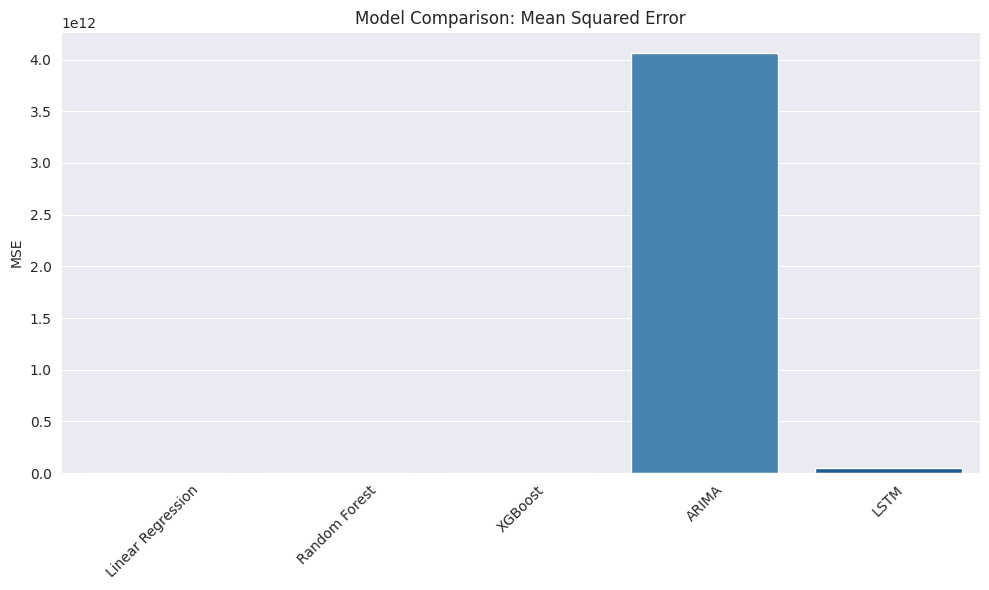

<ipython-input-18-bc59ad9d0293>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_values, palette='Greens')


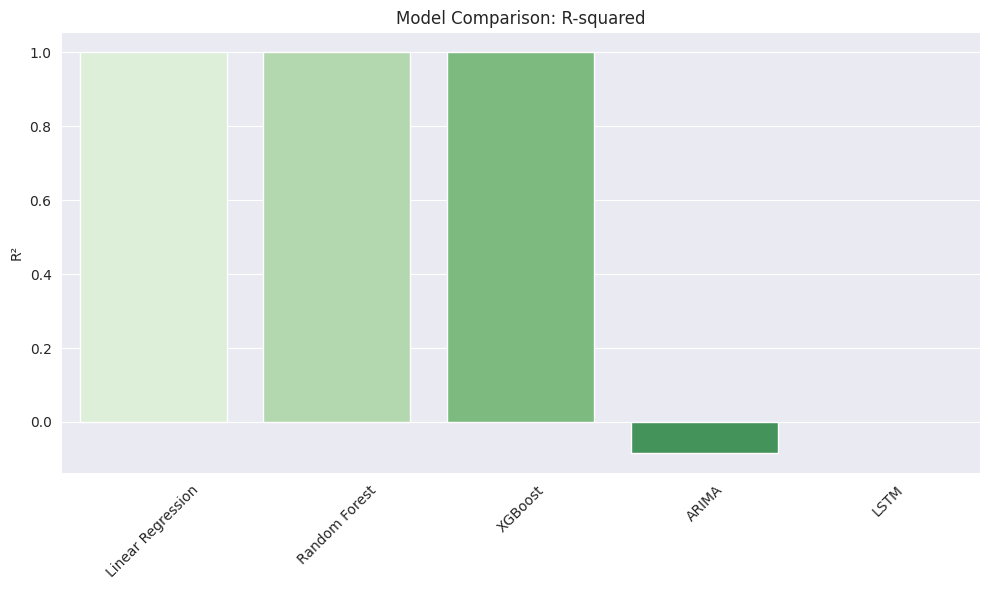

In [18]:
# Compare model performance
if df is not None:
    models = ['Linear Regression', 'Random Forest', 'XGBoost', 'ARIMA', 'LSTM']
    mse_values = [mse_lr, mse_rf, mse_xgb, mse_arima, mse_lstm]
    r2_values = [r2_lr, r2_rf, r2_xgb, r2_arima, r2_lstm]

    # Plot MSE
    plt.figure()
    sns.barplot(x=models, y=mse_values, palette='Blues')
    plt.title('Model Comparison: Mean Squared Error')
    plt.ylabel('MSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot R²
    plt.figure()
    sns.barplot(x=models, y=r2_values, palette='Greens')
    plt.title('Model Comparison: R-squared')
    plt.ylabel('R²')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 7. Visualizations and Insights

<ipython-input-19-345df8d455c3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances[:10], y=sorted_features[:10], palette='viridis')


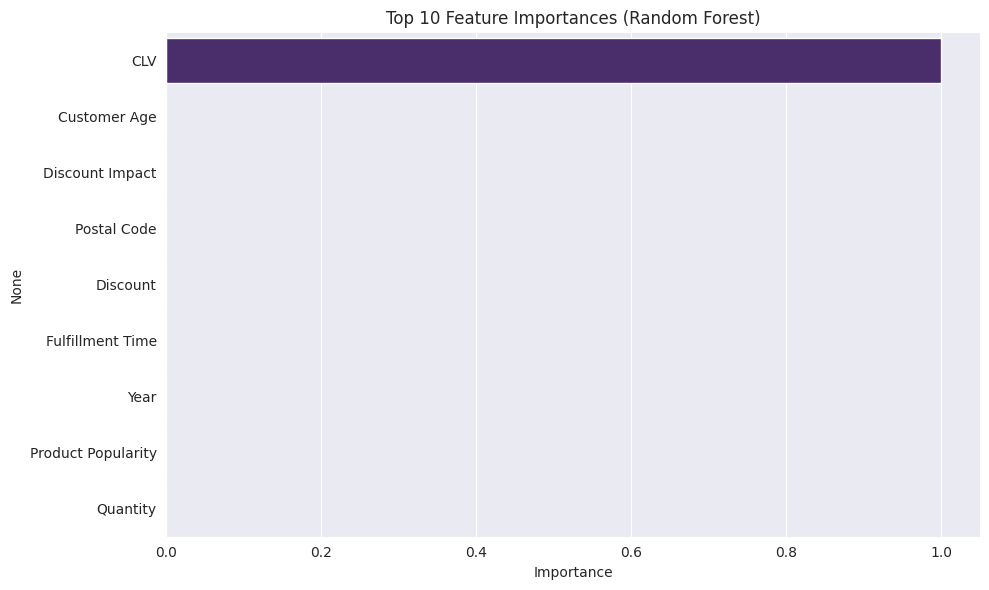

In [19]:
# Plot feature importance
if df is not None:
    importances = rf_model.feature_importances_
    feature_names = X_train.columns
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_features = feature_names[sorted_indices]

    plt.figure()
    sns.barplot(x=sorted_importances[:10], y=sorted_features[:10], palette='viridis')
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

## ARIMA Forecast

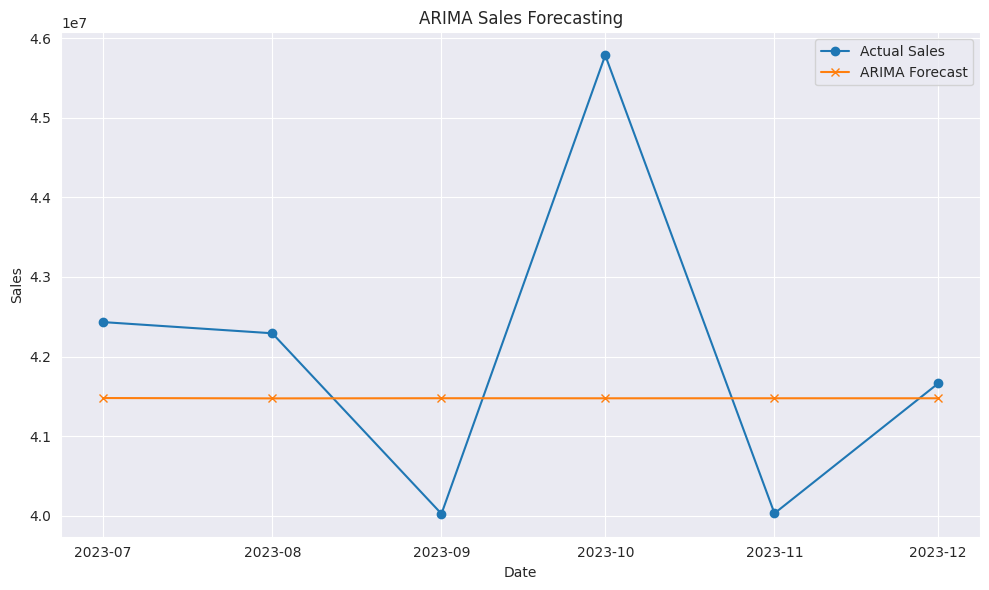

In [20]:
# Plot ARIMA forecast
if df is not None:
    plt.figure()
    plt.plot(test_data.index, test_data['Sales'], label='Actual Sales', marker='o')
    plt.plot(test_data.index, y_pred_arima, label='ARIMA Forecast', marker='x')
    plt.title('ARIMA Sales Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

## LSTM Forecast

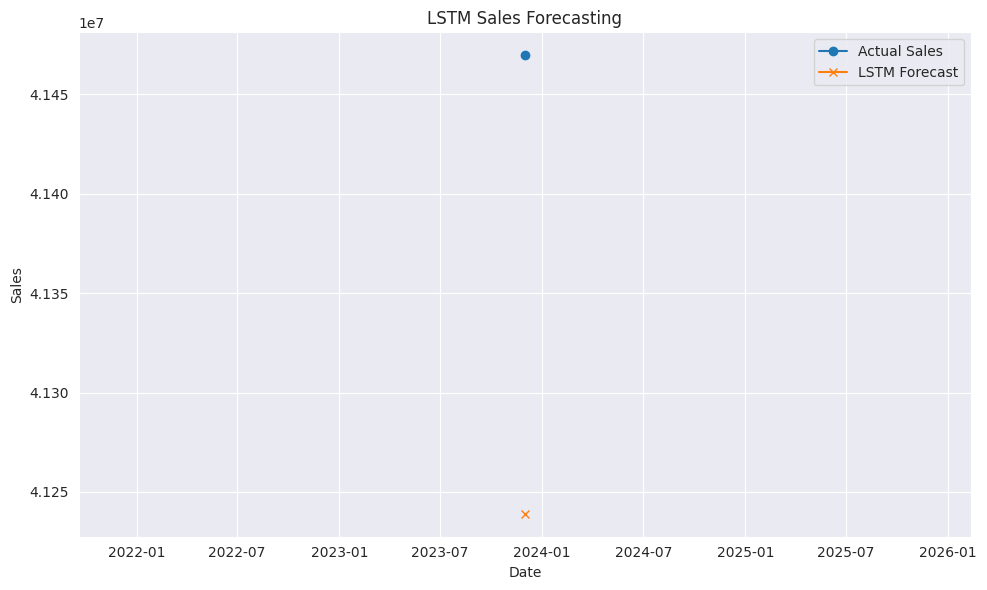

In [22]:
# %% [markdown]
# ### 8.3 LSTM Forecast

# %%
# Plot LSTM forecast
if df is not None:
    plt.figure()
    # Check if test data is sufficient
    if len(y_test_lstm) > 0 and len(test_data.index) >= timesteps + len(y_test_lstm):
        plot_index = test_data.index[timesteps:timesteps + len(y_test_lstm)]
        plt.plot(plot_index, y_test_lstm, label='Actual Sales', marker='o')
        plt.plot(plot_index, y_pred_lstm, label='LSTM Forecast', marker='x')
    else:
        print("Warning: Limited test data for plotting. Showing single-point forecast.")
        # Fallback for single-point prediction
        plt.plot([test_data.index[-1]], y_test_lstm.flatten(), label='Actual Sales', marker='o')
        plt.plot([test_data.index[-1]], y_pred_lstm.flatten(), label='LSTM Forecast', marker='x')

    plt.title('LSTM Sales Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

##Customer Segmentation

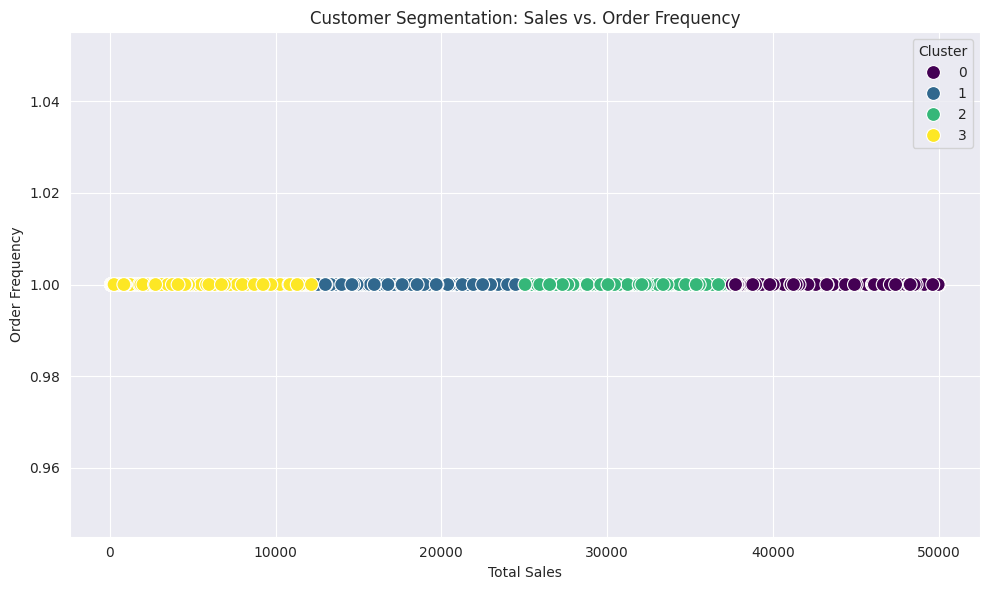

In [23]:
# Customer segmentation
if df is not None:
    customer_data = df.groupby('Customer ID').agg({
        'Sales': 'sum',
        'Order ID': 'nunique'
    }).reset_index()
    customer_data.columns = ['Customer ID', 'Total Sales', 'Order Frequency']

    kmeans = KMeans(n_clusters=4, random_state=42)
    customer_data['Cluster'] = kmeans.fit_predict(customer_data[['Total Sales', 'Order Frequency']])

    plt.figure()
    sns.scatterplot(x='Total Sales', y='Order Frequency', hue='Cluster',
                    data=customer_data, palette='viridis', s=100)
    plt.title('Customer Segmentation: Sales vs. Order Frequency')
    plt.tight_layout()
    plt.show()

## Discount vs. Profit

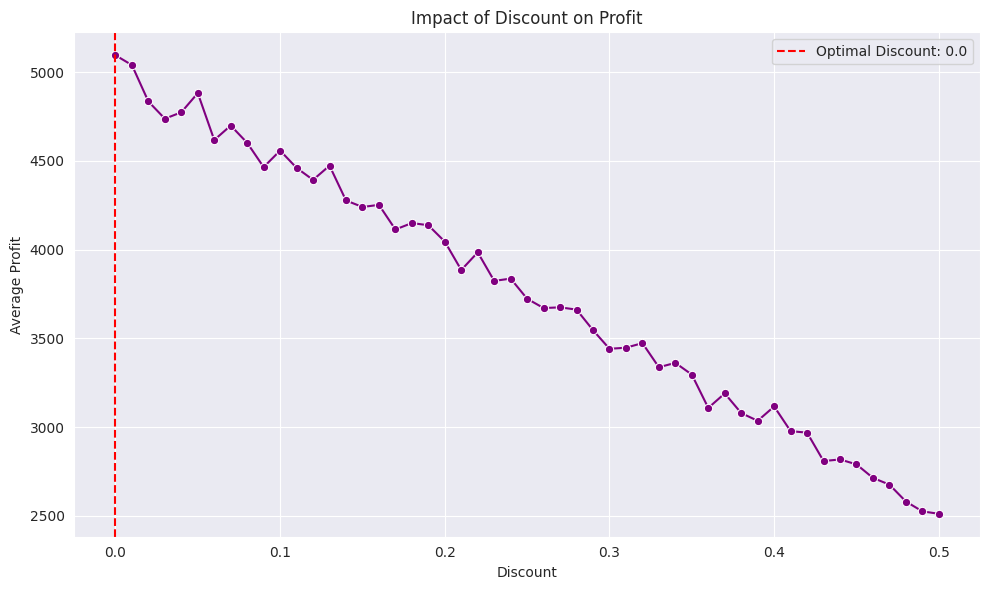

Optimal Discount: 0.0


In [24]:
# Plot discount vs. profit
if df is not None:
    discount_profit = df.groupby('Discount')['Profit'].mean().reset_index()
    plt.figure()
    sns.lineplot(x='Discount', y='Profit', data=discount_profit, marker='o', color='purple')
    optimal_discount = discount_profit.loc[discount_profit['Profit'].idxmax()]
    plt.axvline(x=optimal_discount['Discount'], color='red', linestyle='--',
                label=f'Optimal Discount: {optimal_discount["Discount"]}')
    plt.title('Impact of Discount on Profit')
    plt.xlabel('Discount')
    plt.ylabel('Average Profit')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Optimal Discount: {optimal_discount['Discount']}")

## Inventory Management

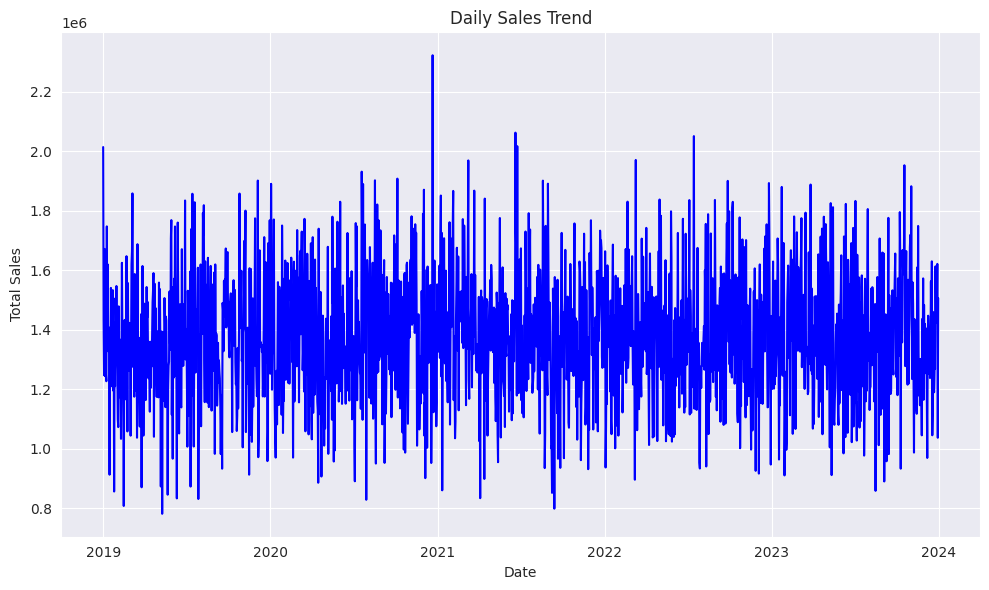

Safety Stock (7-day lead time): 9616148.47


In [25]:
# Calculate and plot daily sales trend
if df is not None:
    daily_sales_trend = df.groupby('Sales Date')['Sales'].sum()
    plt.figure()
    sns.lineplot(x=daily_sales_trend.index, y=daily_sales_trend.values, color='blue')
    plt.title('Daily Sales Trend')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.tight_layout()
    plt.show()

    # Safety stock
    lead_time = 7  # days
    daily_sales = daily_sales_trend.mean()
    safety_stock = daily_sales * lead_time
    print(f"Safety Stock (7-day lead time): {safety_stock:.2f}")

## Correlation Heatmap

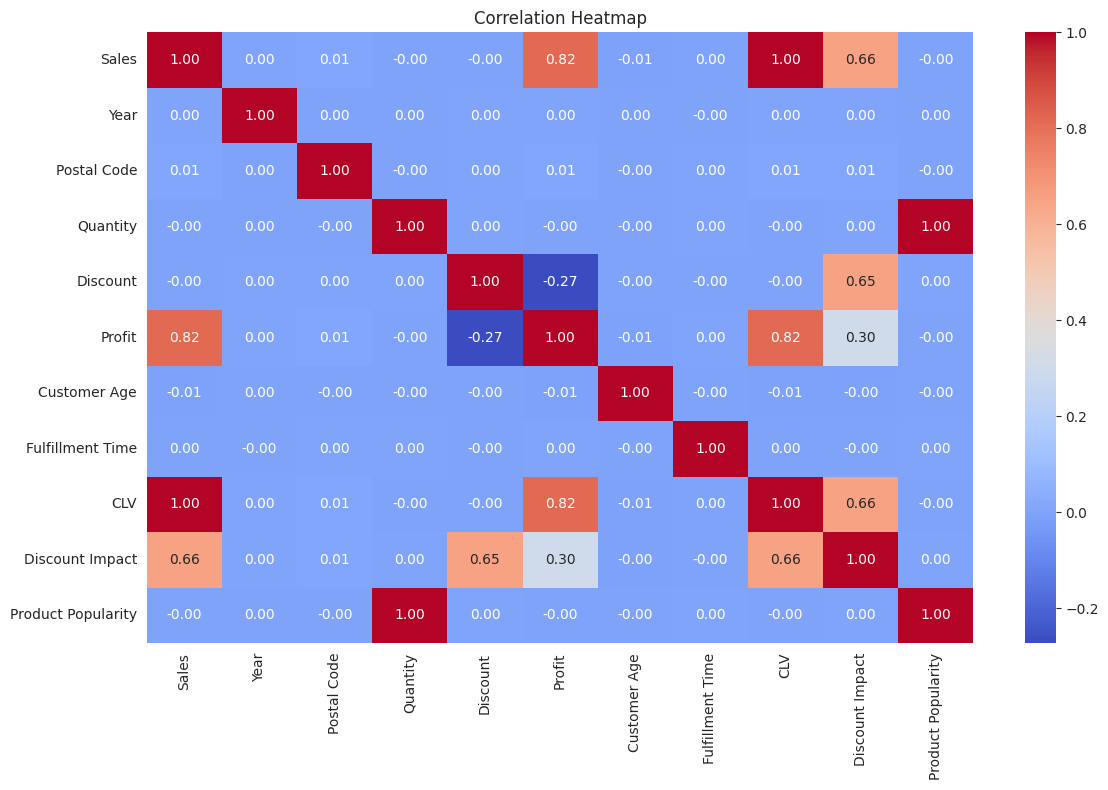

In [26]:
# Plot correlation heatmap
if df is not None:
    numeric_data = df.select_dtypes(include=['number'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

## Sales Distribution

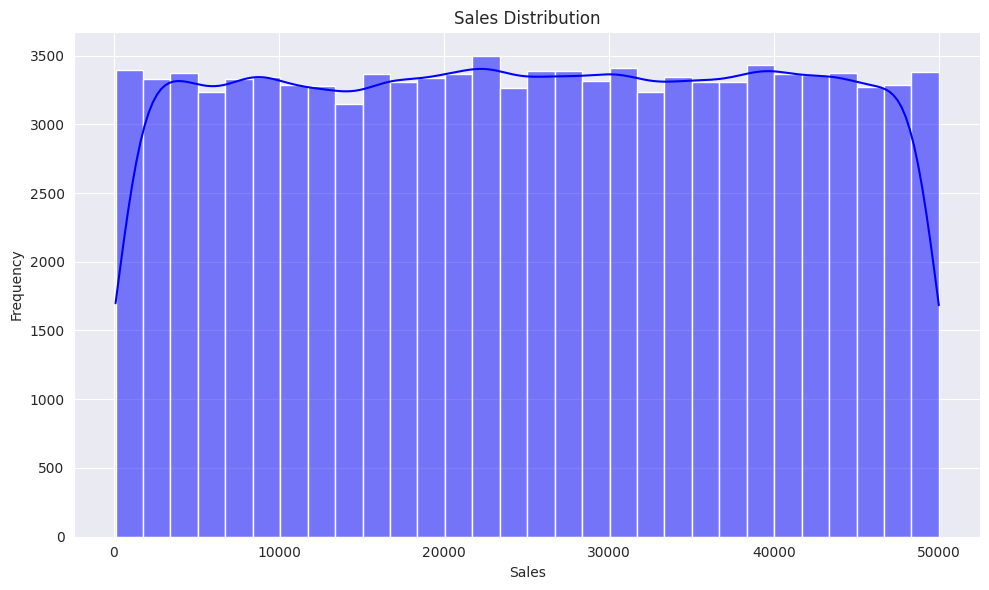

In [27]:
# Plot sales distribution
if df is not None:
    plt.figure()
    sns.histplot(df['Sales'], bins=30, kde=True, color='blue')
    plt.title('Sales Distribution')
    plt.xlabel('Sales')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

## 7.9 Discount vs. Quantity

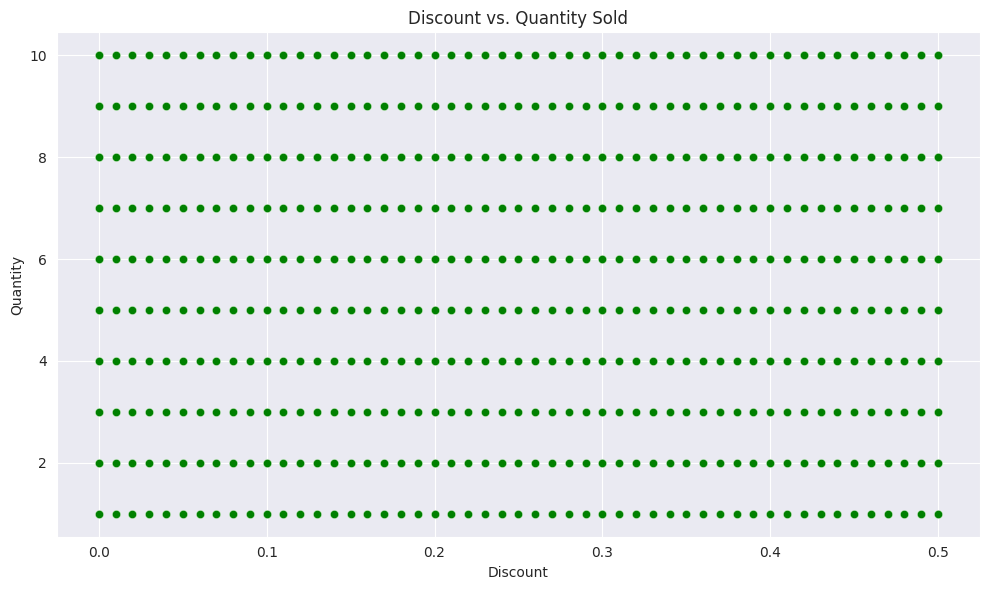

In [28]:
# Plot discount vs. quantity
if df is not None:
    plt.figure()
    sns.scatterplot(x='Discount', y='Quantity', data=df, alpha=0.5, color='green')
    plt.title('Discount vs. Quantity Sold')
    plt.xlabel('Discount')
    plt.ylabel('Quantity')
    plt.tight_layout()
    plt.show()

## Regional Sales Analysis

<ipython-input-29-d93fbafcb36b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Sales', data=region_sales_df, palette='viridis')


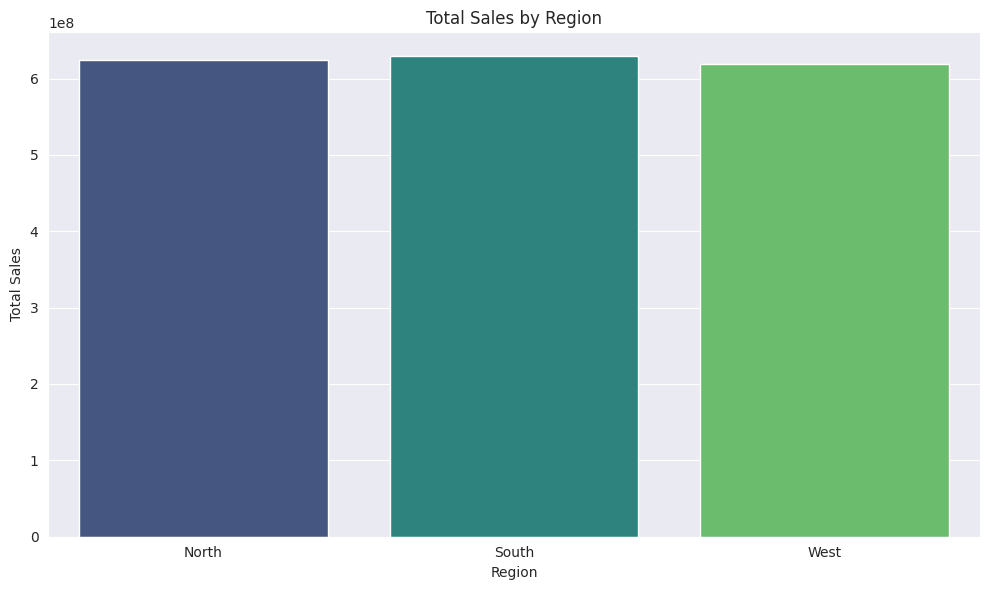

In [29]:
if df is not None:
    region_columns = [col for col in df.columns if col.startswith('Region_')]
    region_sales = {}
    for region in region_columns:
        region_sales[region] = df.loc[df[region] == 1, 'Sales'].sum()

    region_sales_df = pd.DataFrame(list(region_sales.items()),
                                  columns=['Region', 'Sales'])
    region_sales_df['Region'] = region_sales_df['Region'].str.replace('Region_', '')

    plt.figure()
    sns.barplot(x='Region', y='Sales', data=region_sales_df, palette='viridis')
    plt.title('Total Sales by Region')
    plt.xlabel('Region')
    plt.ylabel('Total Sales')
    plt.tight_layout()
    plt.show()